In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def load_data():
    URL = "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
    try:
        df = pd.read_csv(URL, sep=";")
        return df
    except Exception as e:
        raise e

In [3]:
data = load_data()
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pylab, pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
import mlflow

In [5]:
d = pd.read_csv('train.csv')
d.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [6]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [7]:
cat_cols = list(d.select_dtypes(include=['object']).columns)
cat_cols

['Loan_ID',
 'Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area',
 'Loan_Status']

In [8]:
num_cols = list(d.select_dtypes(include=['int64', 'float64']).columns)
num_cols

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History']

In [9]:
cols2remove = ['Loan_ID', 'Loan_Status']
cat_cols = [col for col in cat_cols if col not in cols2remove]
cat_cols
# d.drop(columns=cols2remove, inplace = True)

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area']

In [10]:
# Based on time and importance of the columns, make sure to use the right imputer to fill the missing values. 
# For now we'll use Simple Imputing Strategy
from sklearn.impute import SimpleImputer

num_imp = SimpleImputer(strategy='median')
cat_imp = SimpleImputer(strategy='most_frequent')

d[num_cols] = num_imp.fit_transform(d[num_cols])
d[cat_cols] = cat_imp.fit_transform(d[cat_cols])

In [11]:
d[num_cols].describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,614.000000,614.000000,614.000000
mean,5403.459283,1621.245798,145.752443,342.410423,0.855049
std,6109.041673,2926.248369,84.107233,64.428629,0.352339
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2877.500000,0.000000,100.250000,360.000000,1.000000
50%,3812.500000,1188.500000,128.000000,360.000000,1.000000
75%,5795.000000,2297.250000,164.750000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000


In [12]:
Q1 = d[num_cols].quantile(0.25)
Q3 = d[num_cols].quantile(0.75)
IQR  = Q3- Q1
print(f"Q1 of the given dataset\n{Q1}\n\n Q3 of the given dataset \n{Q3}\n\n IQR of the given dataset\n{IQR}")

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = (d[num_cols] < lower_bound) | (d[num_cols] > upper_bound)

num_outliers = outliers.sum()

Q1 of the given dataset
ApplicantIncome      2877.50
CoapplicantIncome       0.00
LoanAmount            100.25
Loan_Amount_Term      360.00
Credit_History          1.00
Name: 0.25, dtype: float64

 Q3 of the given dataset 
ApplicantIncome      5795.00
CoapplicantIncome    2297.25
LoanAmount            164.75
Loan_Amount_Term      360.00
Credit_History          1.00
Name: 0.75, dtype: float64

 IQR of the given dataset
ApplicantIncome      2917.50
CoapplicantIncome    2297.25
LoanAmount             64.50
Loan_Amount_Term        0.00
Credit_History          0.00
dtype: float64


In [13]:
print("Columns with outliers:")
print(num_outliers[num_outliers > 0])

Columns with outliers:
ApplicantIncome      50
CoapplicantIncome    18
LoanAmount           41
Loan_Amount_Term     88
Credit_History       89
dtype: int64


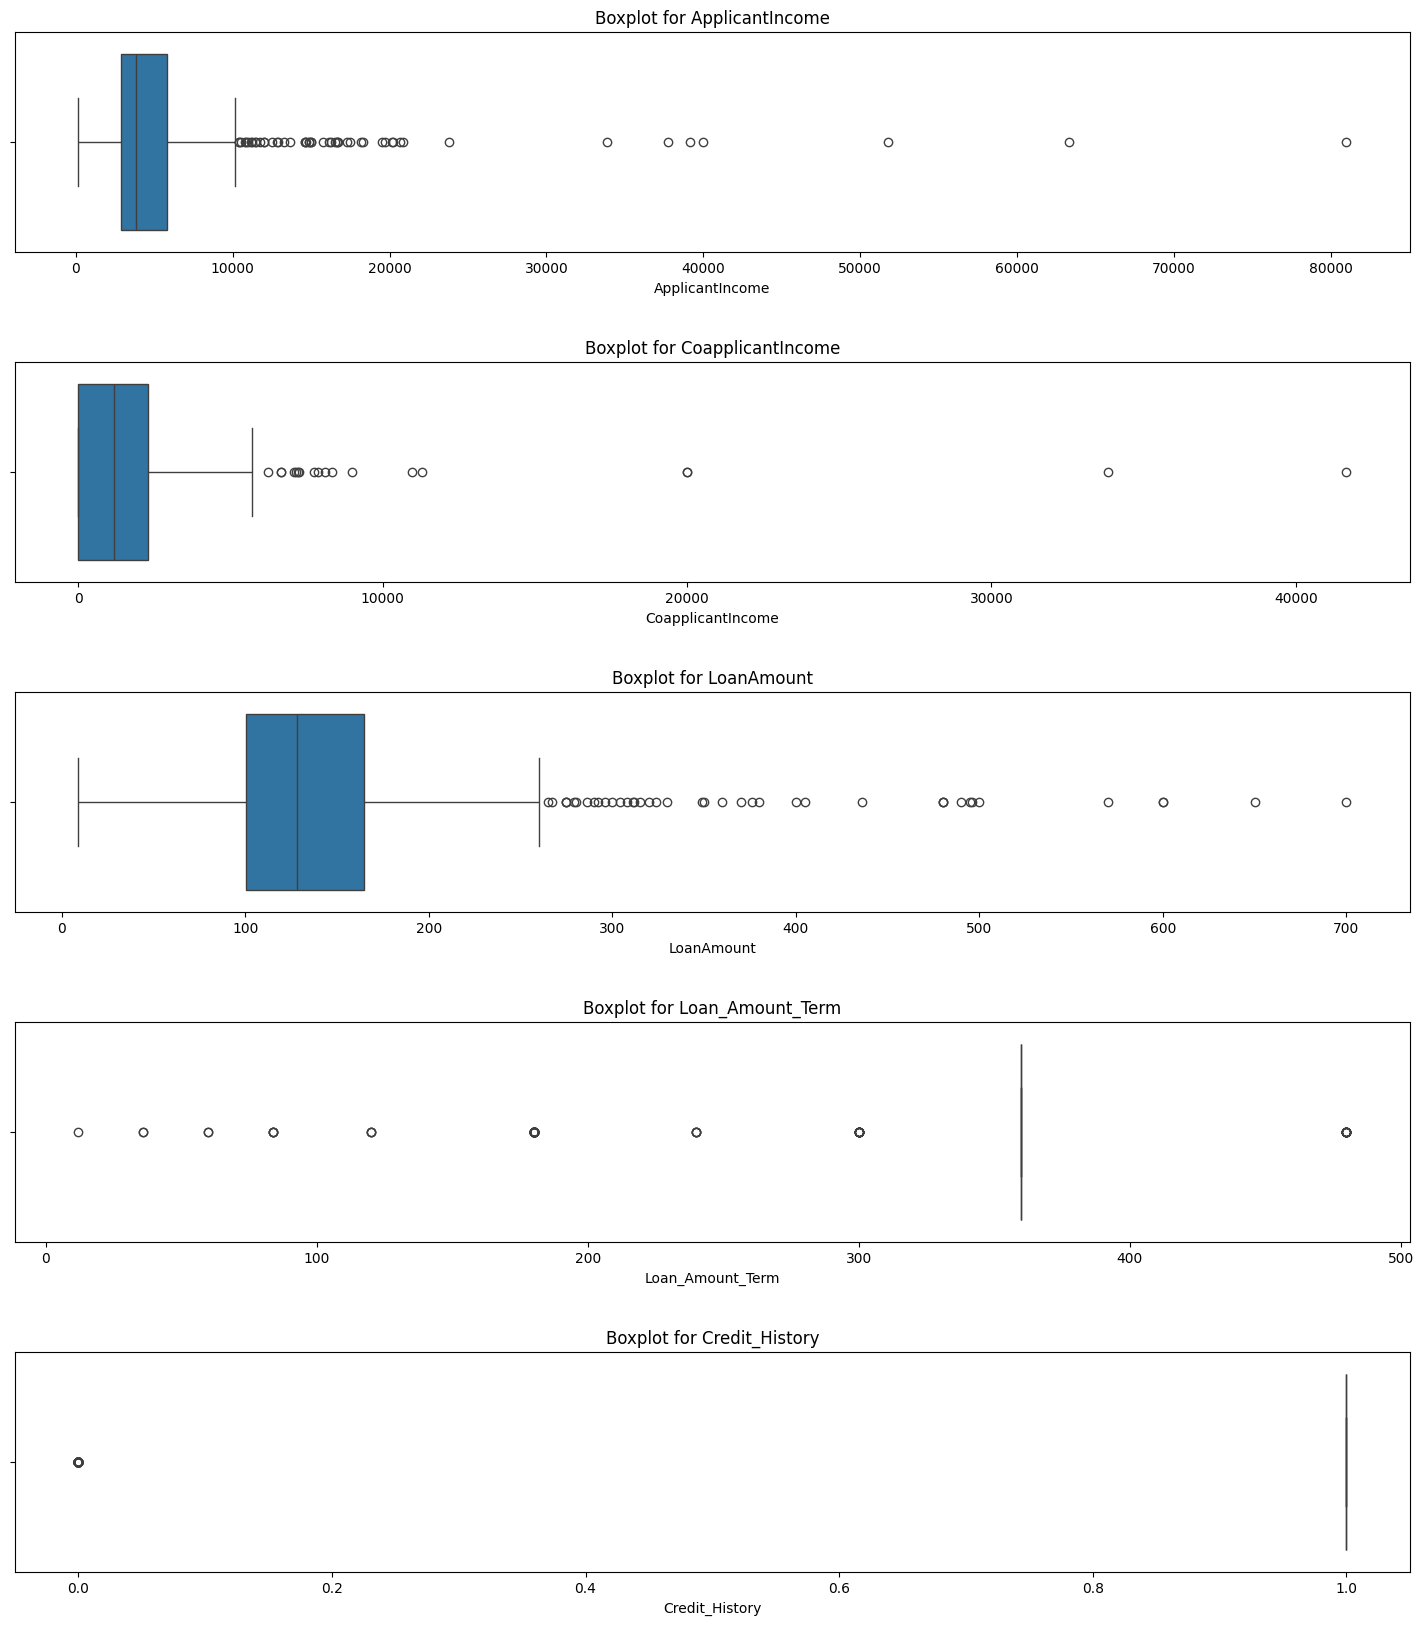

In [14]:
fig, axes = plt.subplots(nrows=len(num_cols), figsize=(18, 4 * len(num_cols)))
plt.subplots_adjust(hspace=0.5)  # Adjust the height space between subplots

for i, column in enumerate(num_cols):
    sns.boxplot(x=d[column], ax=axes[i])
    axes[i].set_title(f'Boxplot for {column}')
    axes[i].set_xlabel(column)

plt.show()

In [15]:
cols_2_transform = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
for col in cols_2_transform:
    d[col] = np.log1p(d[col])

In [16]:
d[cols_2_transform].head(7)
# d[cols_2_transform].isnull().sum()

,ApplicantIncome,CoapplicantIncome,LoanAmount
0,8.674197,0.000000,4.859812
1,8.430327,7.319202,4.859812
2,8.006701,0.000000,4.204693
3,7.857094,7.765993,4.795791
4,8.699681,0.000000,4.955827
5,8.597482,8.342125,5.590987
6,7.755339,7.324490,4.564348


In [17]:
d['TotalIncome'] = d['ApplicantIncome'] + d['CoapplicantIncome']

In [18]:
cols2drop = ['ApplicantIncome','CoapplicantIncome']
d.drop(columns=cols2drop, inplace = True)

In [19]:
d.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome
0,LP001002,Male,No,0,Graduate,No,4.859812,360.0,1.0,Urban,Y,8.674197
1,LP001003,Male,Yes,1,Graduate,No,4.859812,360.0,1.0,Rural,N,15.749530
2,LP001005,Male,Yes,0,Graduate,Yes,4.204693,360.0,1.0,Urban,Y,8.006701
3,LP001006,Male,Yes,0,Not Graduate,No,4.795791,360.0,1.0,Urban,Y,15.623087
4,LP001008,Male,No,0,Graduate,No,4.955827,360.0,1.0,Urban,Y,8.699681


In [20]:
le = LabelEncoder()

for col in cat_cols:
    d[col] = le.fit_transform(d[col])

d['Loan_Status'] = le.fit_transform(d['Loan_Status'])

In [21]:
d.head(7)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome
0,LP001002,1,0,0,0,0,4.859812,360.0,1.0,2,1,8.674197
1,LP001003,1,1,1,0,0,4.859812,360.0,1.0,0,0,15.749530
2,LP001005,1,1,0,0,1,4.204693,360.0,1.0,2,1,8.006701
3,LP001006,1,1,0,1,0,4.795791,360.0,1.0,2,1,15.623087
4,LP001008,1,0,0,0,0,4.955827,360.0,1.0,2,1,8.699681
5,LP001011,1,1,2,0,1,5.590987,360.0,1.0,2,1,16.939607
6,LP001013,1,1,0,1,0,4.564348,360.0,1.0,2,1,15.079829


In [22]:
X = d.drop(columns = ['Loan_ID', 'Loan_Status'])
y = d.Loan_Status
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)
print(f"Size of X_train {X_train.shape} and Size of X_test {X_test.shape}")
print(f"Size of y_train {y_train.shape} and Size of y_test {y_test.shape}")

Size of X_train (429, 10) and Size of X_test (185, 10)
Size of y_train (429,) and Size of y_test (185,)


In [23]:
y_train

164    1
232    1
127    1
196    1
266    1
      ..
419    1
120    1
368    1
48     0
207    1
Name: Loan_Status, Length: 429, dtype: int32

In [24]:
def evaluate_model_performance(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    recall_train = recall_score(y_train, y_pred_train)
    precision_train = precision_score(y_train, y_pred_train)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train)

    y_pred_test = model.predict(X_test)
    recall_test = recall_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)

    print(f"Results for {model.__class__.__name__}:")
    print(f"Train Accuracy: {round(accuracy_train, 4) * 100}%")
    print(f"Test Accuracy: {round(accuracy_test, 4) * 100}%")

    print(f"Train Recall: {round(recall_train, 4) * 100}%")
    print(f"Test Recall: {round(recall_test, 4) * 100}%")

    print(f"Train Precision: {round(precision_train, 4) * 100}%")
    print(f"Test Precision: {round(precision_test, 4) * 100}%")

    print(f"Train F1 Score: {round(f1_train, 4) * 100}%")
    print(f"Test F1 Score: {round(f1_test, 4) * 100}%")

In [25]:
lr = LogisticRegression(max_iter=1000)
dt = DecisionTreeClassifier()
gbc = GradientBoostingClassifier()
abc = AdaBoostClassifier()

In [26]:
evaluate_model_performance(lr, X_train, y_train, X_test, y_test)

Results for LogisticRegression:
Train Accuracy: 80.42%
Test Accuracy: 82.69999999999999%
Train Recall: 98.63%
Test Recall: 96.15%
Train Precision: 78.25999999999999%
Test Precision: 82.24000000000001%
Train F1 Score: 87.27000000000001%
Test F1 Score: 88.64999999999999%


In [27]:
evaluate_model_performance(dt, X_train, y_train, X_test, y_test)

Results for DecisionTreeClassifier:
Train Accuracy: 100.0%
Test Accuracy: 71.35000000000001%
Train Recall: 100.0%
Test Recall: 73.08%
Train Precision: 100.0%
Test Precision: 84.07%
Train F1 Score: 100.0%
Test F1 Score: 78.19%


In [28]:
evaluate_model_performance(gbc, X_train, y_train, X_test, y_test)

Results for GradientBoostingClassifier:
Train Accuracy: 91.38%
Test Accuracy: 80.54%
Train Recall: 99.66000000000001%
Test Recall: 92.31%
Train Precision: 88.99000000000001%
Test Precision: 82.19%
Train F1 Score: 94.02000000000001%
Test F1 Score: 86.96000000000001%


In [29]:
import mlflow

# Get the current tracking URI
tracking_uri = mlflow.get_tracking_uri()

# Print the tracking URI
print("MLflow Tracking URI:", tracking_uri)

MLflow Tracking URI: file:///d:/MLOps/Orignals/MLOps/MLFlow/mlruns


In [32]:
experiment_name = "Loan_Prediction"

try:
    experiment_id = mlflow.create_experiment(experiment_name)
    # print(f"Experiment created with ID: {experiment_id}")
except mlflow.exceptions.MlflowException as e:
    if "already exists" in str(e):
        # print(f"Experiment '{experiment_name}' already exists. Using existing experiment.")
        experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
    else:
        raise e 